RF-default: 0.716 (0.031)
CART-default: 0.671 (0.041)
NB-default: 0.576 (0.043)
NB-std: 0.576 (0.043)
NB-norm: 0.576 (0.043)
KNN-def: 0.559 (0.039)
KNN-std: 0.566 (0.054)
KNN-norm: 0.548 (0.046)
SVM-def: 0.747 (0.052)
SVM-std: 0.748 (0.062)
SVM-norm: 0.748 (0.053)


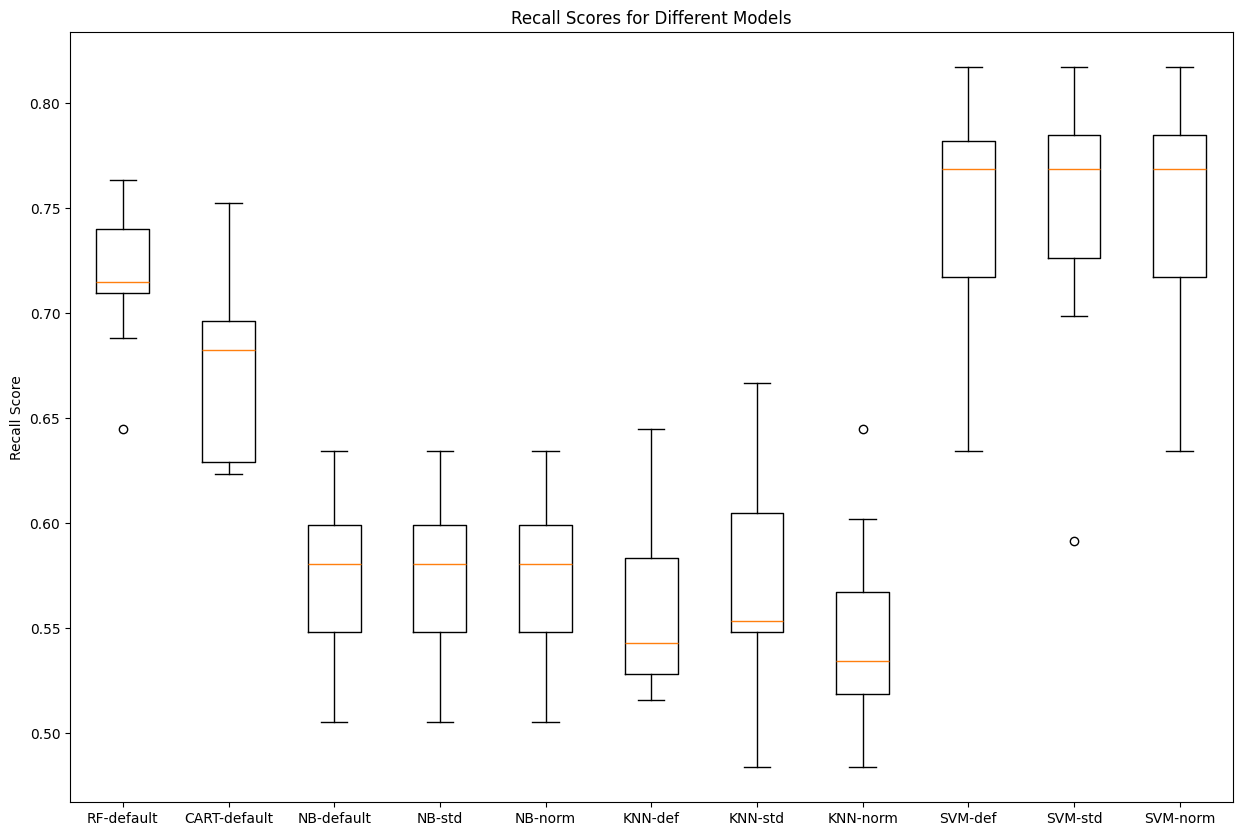

In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('../data/samu_cases_ready.csv')

test_size = 0.2
seed = 42


# why recall?
# We need to reduce the deaths before medical care
# Recall focus on predict the most of cases that are deaths, even if we have some false positives
scoring = 'recall'

X = dataset.drop(columns=['outcome'], axis=1)
y = dataset['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Why reduce the dimensionality with PCA?
# We have more then 10 features
# In medical care context we have a lot of features that are correlated and could be selected between them depending on the agent from SAMU
# At previous tests, some algorithms were overfitting (SVM)
pca = ('pca', PCA(n_components=2, random_state=seed))

y_train = y_train.astype(int)
y_test = y_test.astype(int)

encoder = ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
standard_scaler = ('std', StandardScaler())
min_max_scaler = ('norm', MinMaxScaler())

pipelines = []


RF = ('RF', RandomForestClassifier(random_state=seed))
NB = ('NB', GaussianNB())
KNN = ('KNN', KNeighborsClassifier())
CART = ('CART', DecisionTreeClassifier(random_state=seed))
SVM = ('SVM', SVC(random_state=seed))

# RF pipeline
# Random Forest has a better performance with default values only
# only encoder needed
pipelines.append(('RF-default', Pipeline([encoder, RF]))) 

# CART pipeline
# Decision Tree has a better performance with default values only
# only encoder needed
pipelines.append(('CART-default', Pipeline([encoder, CART])))

# NB pipeline
pipelines.append(('NB-default', Pipeline([encoder, pca, NB])))
pipelines.append(('NB-std', Pipeline([encoder, pca, standard_scaler, NB])))
pipelines.append(('NB-norm', Pipeline([encoder, pca, min_max_scaler, NB])))

# KNN pipeline
pipelines.append(('KNN-def', Pipeline([encoder, pca, KNN])))
pipelines.append(('KNN-std', Pipeline([encoder, pca, standard_scaler, KNN])))
pipelines.append(('KNN-norm', Pipeline([encoder, pca, min_max_scaler, KNN])))


# SVM pipeline
pipelines.append(('SVM-def', Pipeline([encoder, pca, SVM])))
pipelines.append(('SVM-std', Pipeline([encoder, pca, standard_scaler, SVM])))
pipelines.append(('SVM-norm', Pipeline([encoder, pca, min_max_scaler, SVM])))


n_folds = 10
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

scores = []
names = []


for name, model in pipelines:
    names.append(name)
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring=scoring)
    scores.append(score)
    msg = "%s: %.3f (%.3f)" % (name, score.mean(), score.std())
    print(msg)


plt.figure(figsize=(15,10))
plt.boxplot(scores)
plt.title('Recall Scores for Different Models')
plt.ylabel('Recall Score')
plt.xticks(range(1, len(names)+1), names)
plt.show()



### Tunning the SVM

In [118]:
np.random.seed(42)

encoder = ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pca = ('pca', PCA(n_components=2))

pipelines = []
results = []
names = []


SVM = ('SVM', SVC(random_state=seed))
SVM_param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__gamma': [1, 0.1, 0.01, 0.001],
    'SVM__kernel': ['rbf', 'poly', 'sigmoid']
}

pipelines.append(('SVC-default', Pipeline(steps=[encoder, pca, SVM])))
pipelines.append(('SVC-std', Pipeline(steps=[encoder, pca, standard_scaler, SVM])))
pipelines.append(('SVC-norm', Pipeline(steps=[encoder, pca, min_max_scaler, SVM])))


print('🔎 Starting analysis for model with grid search')
print('Grab a ☕️, this should take a while... ⏳')

for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=SVM_param_grid, cv=kfold, scoring='recall')
    grid_result = grid.fit(X_train_resampled, y_train_resampled)
    best_params = {k: float(v) if isinstance(v, np.float64) else v for k, v in grid_result.best_params_.items()}
    results.append(grid_result.best_score_)
    names.append(name)
    print("%s - Better %f with %s" % (name, grid_result.best_score_, best_params))
    
# it takes about 4 min

🔎 Starting analysis for model with grid search
Grab a ☕️, this should take a while... ⏳
SVC-default - Better 0.761588 with {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
SVC-std - Better 0.729364 with {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
SVC-norm - Better 0.700286 with {'SVM__C': 100, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}


#### After applying hyperparameters, the SVC performs better with the dataset's default values, making the use of a scaler or normalizer unnecessary.

#### Testing SVC with unseen data from them model

In [132]:
np.random.seed(42)

model = ('SVM_best_params', SVC(C=10, gamma=1, kernel='rbf'))
pipeline = Pipeline(steps=[encoder, pca, model])


pipeline.fit(X_train_resampled, y_train_resampled)
prediction = pipeline.predict(X_test)
print('Recall:', recall_score(y_test, prediction))



Recall: 0.7607142857142857


##### Simulating new data for prediction:

In [133]:
pipeline.fit(X, y)

new_data = pd.DataFrame({
    'timestamp': ['morning'],
    'type': ['CARDIOLOGICA'],
    'subtype': ['PARADA CARDIACA'],
    'gender': [1],
    'age': [3],
})

prediction = pipeline.predict(new_data)
print(prediction)

[0]


## Conclusion

Even though we had already discretized and manually encoded columns such as "age" and "timestamp" during the EDA and data preprocessing stages, it was still necessary to apply the encoding method within the pipeline to handle non-numeric categorical data, such as "type" and "subtypes". This ensured that the SAMU agent could continue working with the same dynamics as before, without disrupting its operations. 

We also applied the PCA (Principal Component Analysis) strategy. For some machine learning algorithms, PCA helps reduce the dataset's dimensionality, especially given the many features created from encoding the "type" and "subtypes" columns. Additionally, this strategy can prevent overfitting in certain cases.

Since we were handling imbalanced data (95/5), we applied the undersampling strategy to rebalance the dataset during training. This helped ensure that the model did not become biased toward the majority class and improved its ability to detect true positives.

To evaluate the model performance, we used the recall score, as our primary goal was to improve the detection of true positives (death cases), even if it meant accepting some false negatives.

During model training, we tested five types of machine learning algorithms: Random Forest (RF), Decision Tree (CART), Naive Bayes (NB), K-Nearest Neighbors (KNN), and Support Vector Machine (SVM). In addition to using pipelines with encoding, as mentioned earlier, we applied transformations such as MinMaxScaler and StandardScaler to analyze the models' performance under different scaling methods. Initially, SVM showed slightly better performance, with a recall improvement of 0.001. We further fine-tuned the models using GridSearch, testing the scalers and the default feature values to identify the best performing parameters.

Ultimately, we found the best hyperparameters for the SVM model to be: {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}.

Finally, we tested the trained SVM model with the optimal parameters and applied the full pipeline, including encoding and PCA. As a result, we achieved a recall score of over 70%.



## Exporting model with pipeline 

In [134]:
import pickle

X_resampled, y_resampled = undersampler.fit_resample(X, y)
pipeline.fit(X_resampled, y_resampled)

pipeline_filename = 'model_pipeline.pkl'
with open('../models/' + pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)
